<a href="https://colab.research.google.com/github/rinaschiller/detecting-political-bias-deep-learning/blob/master/LTSM_DeepLearningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 890kB 12.5MB/s 
     |████████████████████████████████| 1.0MB 15.5MB/s 
     |████████████████████████████████| 3.8MB 23.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3b69731143474df28898cb7cc766d17cf3b6991fb9882ced81fa682ffd427e98
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import numpy as np
import pandas as pd
import string
import itertools
from scipy import misc

import torch 
from torch.utils import data
from torch import nn
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from collections import defaultdict
from nltk.corpus import stopwords

import json
import sys
import io

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertModel.from_pretrained('bert-base-uncased')
#bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')

stop_words = set(stopwords.words('english'))
stop_words |= set(['', '``', '-', '--'])

In [0]:
#add directory
# baseDir = "drive/My Drive/sem2/DeepLearning/"
baseDir = "drive/My Drive/DL Project/Data/convote_data/stripped/"
dataDir = ""

dem = 0
rep = 1

#number of sentences for each speech. Pad or trim if necessary
MAX_SENT = 10

UNK = '<UNK>'
PAD = '<PAD>'

In [0]:
%ls drive/

ls: cannot access 'drive/': No such file or directory


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_csv(path, train=False, ypath=None):
    data = pd.read_csv(path, names=['text', 'party'])
    xs, ys = data['text'], data['party']

    return xs, ys

def max_speech_len(speeches):
  return max([len(sent) for pp in speeches for sent in pp])

# Don't lemmatize because bert uses its own tokenization approach
#
# Speeches are too long for bert to handle, so we break each one down
# into an array of sentences
def clean(df):
    df = df.str.split(' ')
    # for i, row in enumerate(df, 0):
    #     df[i] = [w for w in row if w not in stop_words]

    for i, row in enumerate(df, 0):
        para_arr, sent_arr = [], []
        for w in row:
            if w in ['.', '?', '!']:
                sent_arr.append(w)
                para_arr.append(sent_arr),
                sent_arr = []
            else:
                sent_arr.append(w)
        df[i] = para_arr

    return df

# tokenize the dataset. encode_plus pads the data to length 512 and adds a masking list
# as well as an attention list, but it seems like those are actually only necesary for
# using Bert as a model. We're just using it as a feature extractor, so we only need the
# encodings.
def bert_tokenize(speeches, labels):
    dataset, newlabels = [], []
    for i, speech in enumerate(speeches, 0):
        pp = []
        for sent in speech:
            sent = tokenizer.encode(
                        sent,
                        #max_length=512,
                        add_special_tokens=True,
                        #pad_to_max_length=True
                    )
            pp.append(torch.tensor(sent).unsqueeze(0))
        # exclude speeches that end up with no content at all from removal of stopwords/punctuations
        if len(pp) > 0:
            # pad and trim speeches so that each one has MAX_SENT sentences.
            # a pad sentence is just the start token (101) and the end token (102) with no content.
            if len(pp) < MAX_SENT:
                pad = [torch.tensor([101, 102]).unsqueeze(0)] * (MAX_SENT - len(pp))
                pp = pad + pp
            dataset.append(pp[:MAX_SENT])
            newlabels.append(1 if labels[i] == 'R' else 0)
    return dataset, newlabels


class BertifiedDataSet(data.Dataset):
    def __init__(self, xs, ys, model):
        self.xs = xs
        self.ys = ys
        self.model = model
        self.data_len = len(self.ys)

    # Each item in the bert output is going to be a tuple, where the first
    # element is the bert representation for every word in a sentence, and the second
    # is the final bert representation for the entire sentence
    def __getitem__(self, idx):
        with torch.set_grad_enabled(False):
            # Get BERT outputs for each sentence in the speech
            sentences = [self.model(sent.cuda()) for sent in self.xs[idx]]
            label = torch.tensor(self.ys[idx]).cuda()

            # Get the hidden state for each sentence, making a MAX_LEN x 1 x 768 tensor
            seq = torch.stack([hidden for full, hidden in sentences]).cuda()


            return seq, label

    def __len__(self):
        return self.data_len

In [0]:
# Load the training data from csv
# TODO: Get filename from whereever its stored in drive
xtrain, ytrain = load_csv(baseDir + 'training_set_strip.csv')
xdev, ydev = load_csv(baseDir + 'development_set_strip.csv')
xtest, ytest = load_csv(baseDir + 'test_set_strip.csv')

# Reduce the dataset by separating tokens, removing stopwords, and splitting
# speeches into sentences.
xtrain = clean(xtrain)
xdev = clean(xdev)
xtest = clean(xtest)

# Convert 2d array of tokens to a 2d array of bert encodings (which are vocab indexes)
xtokens, ytrain = bert_tokenize(xtrain, ytrain)
xdevtokens, ydev = bert_tokenize(xdev, ydev)

Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors


In [0]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('using CUDA')
    bert_model.cuda()

bert_model.eval()
dataset = BertifiedDataSet(xtokens, ytrain, bert_model)
dev_dataset = BertifiedDataSet(xdevtokens, ydev, bert_model)
data_loader = data.DataLoader(dataset, batch_size=512, shuffle=True)
dev_loader = data.DataLoader(dev_dataset, batch_size=512, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=512, shuffle=True)

using CUDA


In [0]:
print(len(dataset.xs), len(dataset.ys))
print(len(dev_dataset.xs), len(dev_dataset.ys))

2735 2735
257 257


# LSTM

In [0]:
# ----- This class is built to work with our data -----
 class LSTM(nn.Module):    
    def __init__(self, dim, h_dim, layers):
        super(LSTM, self).__init__()
        
        self.layers = layers
        self.h_dim = h_dim
        self.dim = dim
        
        self.lstm = nn.LSTM(dim, h_dim, self.layers, batch_first=True)
        self.fc = nn.Linear(h_dim*MAX_SENT, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight, gain = 1.0)
        self.hidden = self.init_hidden()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
    
    def forward(self, xs):
        xs, self.hidden = self.lstm(xs.view(xs.shape[0], xs.shape[1], -1))
        xs = xs.reshape(xs.shape[0], xs.shape[1]*xs.shape[2]) 

        xs = self.fc(xs)

        xs = self.sigmoid(xs)
        return xs
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.h_dim),
                torch.zeros(1, 1, self.h_dim))
    



In [0]:
# ------- This is the training fn I've been using -------
def train_final(epochs, loader, lssfn, opt):    
    lossList = []
    for e in range(epochs):
        l = 0
        print("epoch: {}".format(e))
        for speeches, labels in loader:
            opt.zero_grad()
            #lstm.hidden = lstm.init_hidden()
            
            preds = lstm(speeches)
            loss = lssfn(preds, labels.float())
            
            loss.backward()
            opt.step()
            
            l += loss.item()
        
        lossList.append(l/len(labels))
            
        right = 0
        count = 0
        for devSpeeches, devLabel in dev_loader:
            devOutputs = lstm(devSpeeches)
            devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
            count+= devLabel.size(0)
            right+= (devPred == devLabel).sum().item()
        accuracy = (right*100)/count
        print("Iteration: {}. Loss: {}% Accuracy = {}.".format(e, l, accuracy))
        
    return lossList

In [0]:
dim = 768
h_dim = 5
layers = 5
tag_size = 1
    
# rnn = RNN(len(vocabToId), dim, batch_size, h_dim, layers, tag_size, weights) 
lstm = LSTM(dim, h_dim, layers).cuda()
loss_function = torch.nn.BCELoss() 

In [0]:
lr_rate = 0.001
epochs = 20

optimizer = torch.optim.Adam(lstm.parameters(), lr = lr_rate)
lossList = train_final(epochs, data_loader, loss_function, optimizer)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([175])) that is different to the input size (torch.Size([175, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Iteration: 0. Loss: 4.161393940448761% Accuracy = 50.583657587548636.
epoch: 1
Iteration: 1. Loss: 4.159092545509338% Accuracy = 49.416342412451364.
epoch: 2
Iteration: 2. Loss: 4.159061133861542% Accuracy = 49.416342412451364.
epoch: 3
Iteration: 3. Loss: 4.159998953342438% Accuracy = 49.416342412451364.
epoch: 4
Iteration: 4. Loss: 4.159116566181183% Accuracy = 49.416342412451364.
epoch: 5
Iteration: 5. Loss: 4.160208880901337% Accuracy = 50.583657587548636.
epoch: 6
Iteration: 6. Loss: 4.159566879272461% Accuracy = 50.583657587548636.
epoch: 7
Iteration: 7. Loss: 4.159328281879425% Accuracy = 50.583657587548636.
epoch: 8
Iteration: 8. Loss: 4.158901691436768% Accuracy = 50.583657587548636.
epoch: 9
Iteration: 9. Loss: 4.158938646316528% Accuracy = 50.583657587548636.
epoch: 10
Iteration: 10. Loss: 4.158919930458069% Accuracy = 49.416342412451364.
epoch: 11
Iteration: 11. Loss: 4.158912658691406% Accuracy = 49.416342412451364.
epoch: 12
Iteration: 12. Loss: 4.159019351005554% Accurac

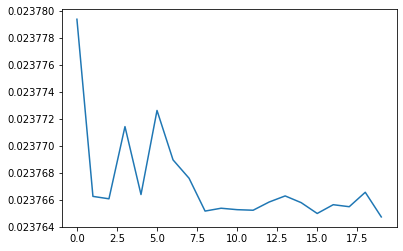

In [0]:
plt.plot(lossList)

In [0]:
def accuracy_score(y_true, y_pred):
    y_pred = np.concatenate(tuple(y_pred))
    y_true = np.concatenate(tuple([[t for t in y] for y in y_true])).reshape(y_pred.shape)
    return (y_true == y_pred).sum() / float(len(y_true))

outputs = lstm(xtest)

IndexError: ignored

# RNN


In [0]:
 class RNN(nn.Module):    
    def __init__(self, vocab, dim, batch_size, h_dim, layers, tag_size, preTrainedWeights):
        super(RNN, self).__init__()
        
        self.layers = layers
        self.batch_size = batch_size
        self.h_dim = h_dim
        self.dim = dim
        
        self.embedding = nn.Embedding.from_pretrained(preTrainedWeights)
        self.gru = nn.GRU(dim, h_dim, self.layers, batch_first=True)
        self.fc = nn.Linear(h_dim*MAX_SENT, tag_size)
        self.relu = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight, gain = 1.0)
        #self.embedding.weight = nn.init.xavier_normal_(self.embedding.weight, gain = 1.0)
        self.hidden = self.init_hidden()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
    
    def forward(self, x):
        xshape = x.shape
        x = self.embedding(x)
        #print(x.shape)
        x, self.hidden = self.gru(x)
        #print(x.shape)
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]) 
        #print(x.shape)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        x = self.sigmoid(x)
        #x = nn.functional.log_softmax(x, dim = 1)
        return x
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.h_dim),
                torch.zeros(1, 1, self.h_dim))
        

optimizer = torch.optim.Adam(rnn.parameters(), lr=lr_rate)
lossList = train(epochs)

In [0]:
def filterPreds(preds, labels):
    preds = preds[labels > 0]
    labels = labels[labels > 0]
    
    return preds, labels
    
def train(epochs):    
    lossList = []
    for e in range(epochs):
        l = 0
        print("epoch: {}".format(e))
        for sent, labels in train_loader:
            rnn.zero_grad()
            rnn.hidden = rnn.init_hidden()
            
            preds = rnn(sent)
            
            #print(preds.shape)
            #print(labels.shape)
            
            #preds, labels = filterPreds(preds, labels)
            
            loss = criterion(preds, labels.float())
            
            loss.backward()
            optimizer.step()
            
            l += loss.item()
        
        lossList.append(l/len(labels))
            
        if e%5==0:
            right = 0
            count = 0
            for devSent, devLabel in dev_loader:
                devOutputs = rnn(devSent)
                devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
                count+= devLabel.size(0)
                right+= (devPred == devLabel).sum().item()
            accuracy = (right*100)/count
            print("Iteration: {}. Loss: {}. Accuracy: {}%.".format(e, loss.item(), accuracy))
        
    return lossList


In [0]:
right = 0
count = 0
for devSent, devLabel in dev_loader:
    devOutputs = rnn(devSent)
    devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
    count+= devLabel.size(0)
    right+= (devPred == devLabel).sum().item()
accuracy = (right*100)/count
print("Accuracy: {}%.".format(accuracy))

Accuracy: 80.26666666666667%.


In [0]:
right = 0
count = 0
for devSent, devLabel in test_loader:
    devOutputs = rnn(devSent)
    devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
    count+= devLabel.size(0)
    right+= (devPred == devLabel).sum().item()
accuracy = (right*100)/count
print("Accuracy: {}%.".format(accuracy))

Accuracy: 77.7%.


In [0]:
class MLP(nn.Module):    
    def __init__(self, vocab, dim, batch_size, h_dim, layers, tag_size, preTrainedWeights):
        super(MLP, self).__init__()
        
        self.layers = layers
        self.batch_size = batch_size
        self.h_dim = h_dim
        self.dim = dim
        
        self.embedding = nn.Embedding.from_pretrained(preTrainedWeights)
        self.fc1 = nn.Linear(dim, h_dim)
        self.fc2 = nn.Linear(h_dim*MAX_SENT, tag_size)
        self.relu = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.fc1.weight = nn.init.xavier_normal_(self.fc1.weight, gain = 1.0)
        self.fc2.weight = nn.init.xavier_normal_(self.fc2.weight, gain = 1.0)
        #self.embedding.weight = nn.init.xavier_normal_(self.embedding.weight, gain = 1.0)
        #self.hidden = self.init_hidden()
        #self._init_weights()

    def forward(self, x):
        xshape = x.shape
        x = self.embedding(x)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]) 
        #print(x.shape)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = self.sigmoid(x)
        #x = nn.functional.log_softmax(x, dim = 1)
        return x
    
    
h_dim = 5
layers = 1
tag_size = 1
    
mlp = MLP(len(vocabToId), dim, batch_size, h_dim, layers, tag_size, weights)  
criterion = torch.nn.BCELoss() 

In [0]:
def trainMLP(epochs):    
    lossList = []
    for e in range(epochs):
        l = 0
        print("epoch: {}".format(e))
        for sent, labels in train_loader:
            mlp.zero_grad()
            preds = mlp(sent)
            
            #print(preds.shape)
            #print(labels.shape)
            
            #preds, labels = filterPreds(preds, labels)
            
            loss = criterion(preds, labels.float())
            
            loss.backward()
            optimizer.step()
            
            l += loss.item()
        
        lossList.append(l/len(labels))
            
        if e%5==0:
            right = 0
            count = 0
            for devSent, devLabel in dev_loader:
                devOutputs = mlp(devSent)
                devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
                count+= devLabel.size(0)
                right+= (devPred == devLabel).sum().item()
            accuracy = (right*100)/count
            print("Iteration: {}. Loss: {}. Accuracy: {}%.".format(e, loss.item(), accuracy))
        
    return lossList


In [0]:
lr_rate = 0.001
epochs = 25

optimizer = torch.optim.Adam(mlp.parameters(), lr=lr_rate)
lossListMLP = trainMLP(epochs)

epoch: 0
Iteration: 0. Loss: 0.6995187401771545. Accuracy: 51.06666666666667%.
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
Iteration: 5. Loss: 0.5408822894096375. Accuracy: 59.733333333333334%.
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
Iteration: 10. Loss: 0.45981308817863464. Accuracy: 65.46666666666667%.
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
Iteration: 15. Loss: 0.3830942213535309. Accuracy: 67.86666666666666%.
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
Iteration: 20. Loss: 0.27639082074165344. Accuracy: 69.73333333333333%.
epoch: 21
epoch: 22
epoch: 23
epoch: 24


In [0]:
right = 0
count = 0
for devSent, devLabel in dev_loader:
    devOutputs = mlp(devSent)
    devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
    count+= devLabel.size(0)
    right+= (devPred == devLabel).sum().item()
accuracy = (right*100)/count
print("Accuracy: {}%.".format(accuracy))

Accuracy: 71.06666666666666%.


In [0]:
right = 0
count = 0
for devSent, devLabel in test_loader:
    devOutputs = mlp(devSent)
    devPred = (devOutputs > 0.5).reshape(devOutputs.shape[0]).long()
    count+= devLabel.size(0)
    right+= (devPred == devLabel).sum().item()
accuracy = (right*100)/count
print("Accuracy: {}%.".format(accuracy))

Accuracy: 69.5%.
